# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Посмотрим размер выборки. Данные взяты с сайта *ChaLearn Looking at People*. Они находятся в папке `/datasets/faces/` на платформе.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Посмотрим общую информацию о датасете.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим первые строки датасета, чтобы узнать, как он выглядит.

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Датасет представляет собой таблицу из двух столбцов:
    
* столбец `file_name` представлен строковыми значениями (названиями файлов),
* столбец `real_age` содержит целочисленные значения (возраст).

Делаем вывод, что тиры данных соответствуют поставленной задаче.

Построим график распределения возраста в выборке.

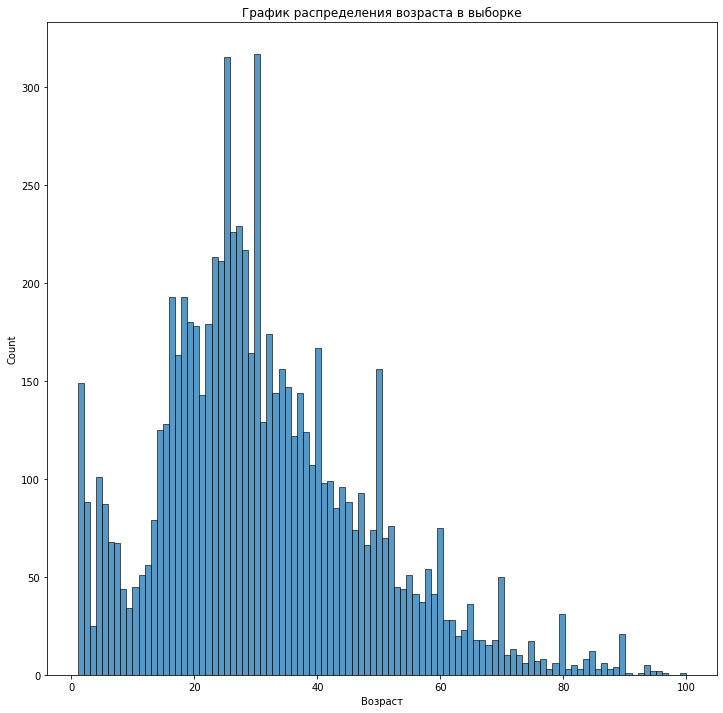

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
sns.histplot(labels['real_age'], ax=ax, bins=100)
ax.set_title('График распределения возраста в выборке')
ax.set_xlabel('Возраст')
plt.show();

Напечатаем 15 фотографий и посмотрим, как устроен датасет.

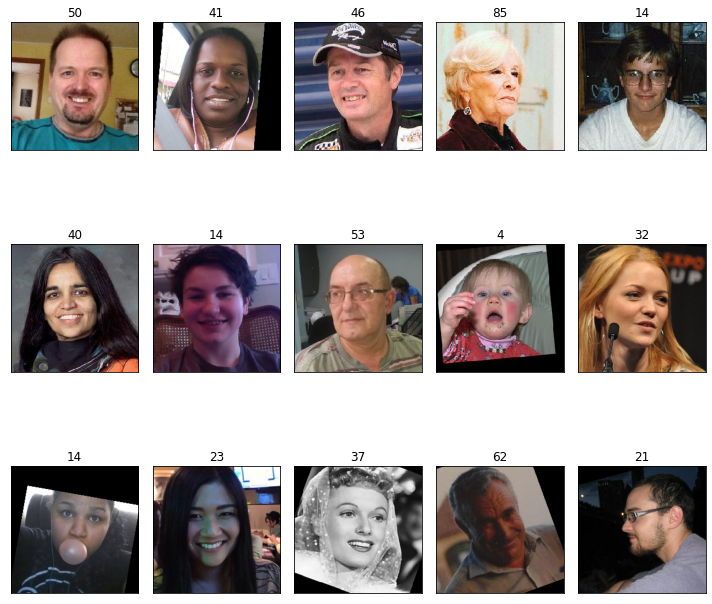

In [6]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(features[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(target[i])

plt.tight_layout()
plt.show();

**Выводы:**
    
Предоставленная выборка состоит из 7591 изображения разного размера (цветные и черно-белые фото), которые приведены к квадратным изображениям размером 224x224, ориентация стандартная.

Из графика распределения видно, что в датасете представлены фотографии людей разного возраста от 1 года до 100 лет. Наибольшее количество фотографий принадлежит людям от 20 до 30 лет. В датасете содержится разное количество фотографий для разных возрастов. Из гистограммы видно, что фотографий людей после 70 лет значительно меньше. Небольшое количество фотографий может негавтино отразится в будущем на качестве обучения модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

**Код модели:**

```python

import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       rescale=1. / 255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + "/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1. / 255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

**Результат вывода на экран:**

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
2024-03-17 10:12:33.628775: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-17 10:12:34.741158: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 68s - loss: 242.6616 - mae: 11.0837 - val_loss: 736.0303 - val_mae: 22.1911
Epoch 2/5
178/178 - 39s - loss: 77.2567 - mae: 6.6514 - val_loss: 667.5314 - val_mae: 20.6542
Epoch 3/5
178/178 - 39s - loss: 48.6584 - mae: 5.3078 - val_loss: 283.8009 - val_mae: 12.4409
Epoch 4/5
178/178 - 39s - loss: 36.0126 - mae: 4.5339 - val_loss: 119.8828 - val_mae: 8.3323
Epoch 5/5
178/178 - 39s - loss: 28.1043 - mae: 4.0674 - val_loss: 82.4926 - val_mae: 6.9897

60/60 - 10s - loss: 82.4926 - mae: 6.9897
Test MAE: 6.9897

```

**Выыод:**
    
Модель обучена, достигнуто значение метрики *MAE* ниже `8`.

## Анализ обученной модели

В ходе выполнения проекта обучена модель определения возраста человека по фотографии, в соответствии с заданием достигнуто значение метрики *MAE* ниже 8 (`6.99`).

Для повышения качества модели использовались:

* аугментация данных (горизонтальное отражение изображений),
* алгоритм *Adam* со значением `learning rate = 0.0001`,
* архитектура *RestNet50* с количеством эпох `5`.

Полученная модель предоставляет бизнесу возможность повысить эффективность и точность анализа данных о покупках, а также обеспечивает возможность более целенаправленного маркетинга и персонализации своего товарного предложения для покупателей определенной возрастной группы. С помощью этой модели бизнес сможет контролировать соблюдение законодательства и добросовестность своих кассиров при продаже алкоголя, что поможет снизить риски связанные с неправильной продажей товаров определенным категориям клиентов. Таким образом, модель способствует оптимизации бизнес-процессов, улучшению качества обслуживания клиентов и увеличению общей прибыли компании.